# Day 8: Model Calibration

## Package: ffn
* https://pmorissette.github.io/ffn/
* Installation:
    ```bash
    pip install ffn
    ```

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import ffn

matplotlib.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True

prices = ffn.get('2330.TW, 2317.TW', start = "2018-1-1")
prices.tail()

2330tw     2317tw
Date                         
2019-06-14   236.0  75.099998
2019-06-17   233.0  76.400002
2019-06-18   235.5  75.900002
2019-06-19   244.0  77.199997
2019-06-20   245.0  77.699997

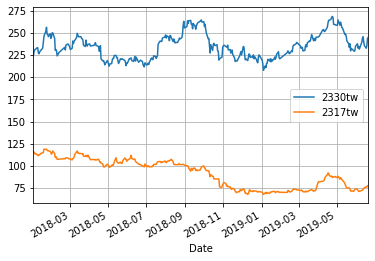

In [2]:
prices.plot()

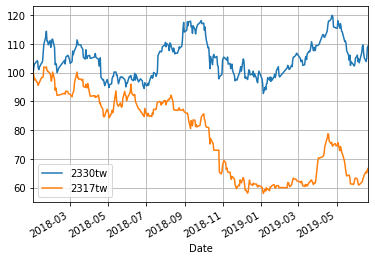

In [3]:
prices.rebase().plot()

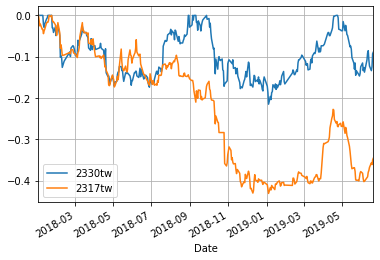

In [4]:
prices.to_drawdown_series().plot()

In [5]:
prices.corr().as_format('.2f')

2330tw 2317tw
2330tw   1.00   0.15
2317tw   0.15   1.00

<module 'matplotlib.pyplot' from 'C:\\Users\\Zheng-Liang Lu\\.conda\\envs\\Quantlib\\lib\\site-packages\\matplotlib\\pyplot.py'>

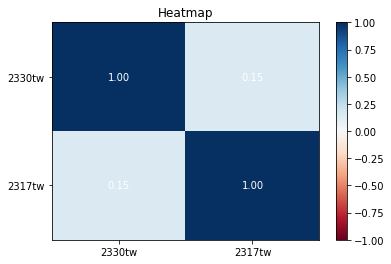

In [6]:
prices.plot_corr_heatmap()

In [7]:
stats = prices.calc_stats()
stats.display()

Stat                 2330tw      2317tw
-------------------  ----------  ----------
Start                2018-01-02  2018-01-02
End                  2019-06-20  2019-06-20
Risk-free rate       0.00%       0.00%

Total Return         9.22%       -33.32%
Daily Sharpe         0.37        -0.95
Daily Sortino        0.61        -1.47
CAGR                 6.22%       -24.21%
Max Drawdown         -21.51%     -43.12%
Calmar Ratio         0.29        -0.56

MTD                  4.03%       5.14%
3m                   1.24%       7.32%
6m                   10.86%      8.67%
YTD                  8.65%       9.75%
1Y                   12.36%      -23.68%
3Y (ann.)            6.22%       -24.21%
5Y (ann.)            -           -
10Y (ann.)           -           -
Since Incep. (ann.)  6.22%       -24.21%

Daily Sharpe         0.37        -0.95
Daily Sortino        0.61        -1.47
Daily Mean (ann.)    9.61%       -25.34%
Daily Vol (ann.)     25.73%      26.69%
Daily Skew           -0.27       -0.19

## Option Pricing by QuantLib
* QuantLib: https://www.quantlib.org/
    * QuantLib is a free/open-source library for quantitative finance.
    * QuantLib is written in C++ with a clean object model, and is then exported to different languages such as C#, Objective Caml, Java, Perl, Python, GNU R, Ruby, and Scheme.
    * Documentation: https://www.quantlib.org/docs.shtml
* Installation:
    * https://www.quantlib.org/install/windows-python.shtml
    ```bash
    pip install QuantLib-Python
    ```
    * https://github.com/lballabio/QuantLib-SWIG/tree/master/Python

In [8]:
from QuantLib import *

### Time
* Date: calendar days and **business days** (depending on your country/region)

In [9]:
date = Date(19, June, 2019)
print(date)

June 19th, 2019


In [10]:
us_calendar = UnitedStates()
tw_calendar = Taiwan()

In [11]:
period = Period(30, Days)
raw_date = date + period                     # calendar days
us_date = us_calendar.advance(date, period)  # business days
tw_date = tw_calendar.advance(date, period)

print("Add 60 days: {0}".format(raw_date))
print("Add 60 business days in US: {0}".format(us_date))
print("Add 60 business days in Taiwan: {0}".format(tw_date))

Add 60 days: July 19th, 2019
Add 60 business days in US: August 1st, 2019
Add 60 business days in Taiwan: July 31st, 2019


In [12]:
busdays = tw_calendar.businessDaysBetween(Date(28, 1, 2019), Date(11, 2, 2019))
print(busdays) # should be 4 bdays?

10


#### Joint Calendar

In [13]:
joint_calendar = JointCalendar(us_calendar, tw_calendar)
busdays = joint_calendar.businessDaysBetween(Date(3, June, 2019), Date(19, June, 2019))
print(busdays)

12


### European Option Prices in Black-Scholes Universe

In [14]:
d1 = Date(19, June, 2019)
d2 = Date(19, June, 2019) + Period(1, Years)

In [15]:
Settings.instance().evaluationDate = d1
payoff = PlainVanillaPayoff(Option.Call, 110.0)
exercise = EuropeanExercise(d2)
call_option = EuropeanOption(payoff, exercise)

In [16]:
spot = SimpleQuote(100.0)

In [17]:
r = FlatForward(d1, 0.05, Actual365Fixed())
v = BlackConstantVol(d1, TARGET(), 0.25, Actual365Fixed())

In [18]:
process = BlackScholesProcess(QuoteHandle(spot), 
                              YieldTermStructureHandle(r), 
                              BlackVolTermStructureHandle(v))
call_option.setPricingEngine(AnalyticEuropeanEngine(process))

In [19]:
print(call_option.NPV())

8.04546049762817


In [20]:
print(call_option.delta())
print(call_option.gamma())
print(call_option.vega())

0.47795983226663774
0.015911550436010703
39.88785931219122


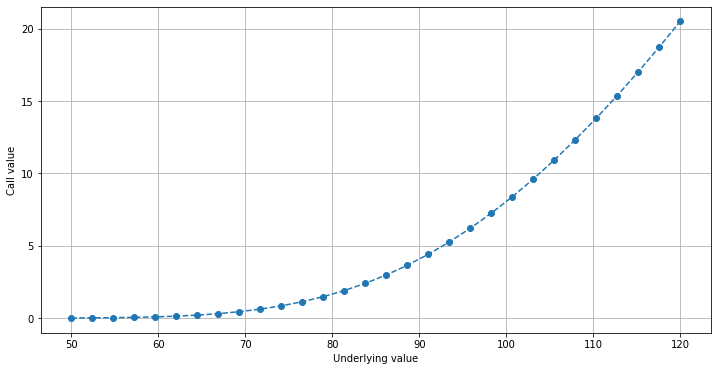

In [21]:
import numpy as np
import matplotlib.pyplot as plt

spots = np.linspace(50.0, 120.0, 30)
ys = []
for item in spots:
    spot.setValue(item)
    ys.append(call_option.NPV())

plt.figure(figsize = (12, 6))
plt.plot(spots, ys, 'o--')
plt.grid(True)
plt.xlabel("Underlying value")
plt.ylabel("Call value")
plt.show()

#### Exercise: American Put

In [22]:
put = VanillaOption(PlainVanillaPayoff(Option.Put, 110), AmericanExercise(d1, d2))

In [23]:
put.setPricingEngine(BinomialVanillaEngine(process, "CRR", 100))
print("American put = ", put.NPV())

American put =  5.435465642727604


### European Option Prices in Heston's Universe

In [24]:
process = HestonProcess(YieldTermStructureHandle(r), 
                        YieldTermStructureHandle(FlatForward(d1, 0.0, Actual360())), 
                        QuoteHandle(spot),
                        0.0625,
                        3,
                        0.0625,
                        0.1,
                        -0.75)

call_option.setPricingEngine(AnalyticHestonEngine(HestonModel(process)))

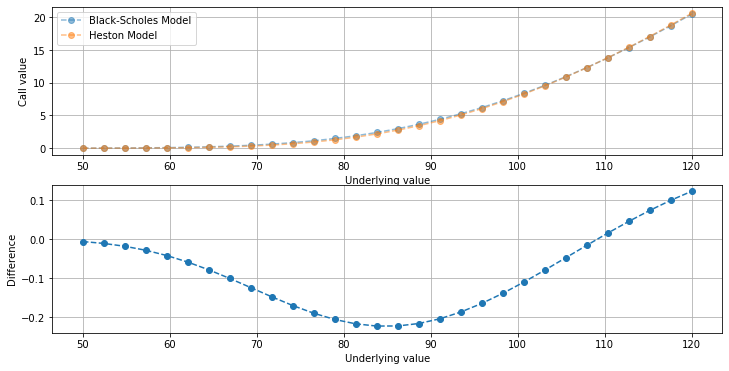

In [25]:
ys2 = []
for item in spots:
    spot.setValue(item)
    ys2.append(call_option.NPV())

plt.figure(figsize = (12, 6))
plt.subplot(211)
plt.plot(spots, ys, 'o--',  alpha = 0.5)
plt.plot(spots, ys2, 'o--', alpha = 0.5)
plt.grid(True)
plt.xlabel("Underlying value")
plt.ylabel("Call value")
plt.legend({"Black-Scholes Model", "Heston Model"})

plt.subplot(212)
plt.plot(spots, [x2 - x1 for x1, x2 in zip(ys, ys2)], 'o--')
plt.xlabel("Underlying value")
plt.ylabel("Difference")
plt.grid(True)

plt.show()

In [26]:
spot.setValue(99)
c1 = call_option.NPV()
spot.setValue(101)
c2 = call_option.NPV()
delta = (c2 - c1) / 2
print('Delta = ', delta)

Delta =  0.49005710140270153


#### Exercise: Try to calculate its greeks like gamma, vega, theta.

### Common Approaches to Option Pricing
* Analytic methods: closed-form solution
* PDE methods: finite-difference
* Lattice methods: binomial tree
* Monte Carlo simulation

In [27]:
call_option = EuropeanOption(payoff, exercise)
process = BlackScholesProcess(QuoteHandle(SimpleQuote(100.0)), 
                              YieldTermStructureHandle(r), 
                              BlackVolTermStructureHandle(v))

call_option.setPricingEngine(AnalyticEuropeanEngine(process))
value = call_option.NPV()
refValue = value

In [28]:
def report(method, x, dx=None):
    e = "{:.4f}".format(abs(x - refValue))
    x = "{:.4f}".format(x)
    if dx:
        dx = "{:.4f}".format(dx)
    else:
        dx = "n/a"
        
    print(" |".join(["{:>17s}".format(y) for y in [method, x, dx, e]]))

In [29]:
header = " |".join(["{:>17s}".format(tag) for tag in ["Method", "Value", "Standard Error", "Actual Error"]])
print("")
print(header)
print("-" * len(header))

report("analytic", value)

timeSteps = 51

call_option.setPricingEngine(BinomialVanillaEngine(process, "CRR", timeSteps))
report("binomial (CRR)", call_option.NPV())

gridPoints = 50

call_option.setPricingEngine(FDEuropeanEngine(process, timeSteps, gridPoints))
report("finite diff.", call_option.NPV())

call_option.setPricingEngine(MCEuropeanEngine(process, "pseudorandom", timeSteps = 1, requiredTolerance = 0.02))
report("MC (crude)", call_option.NPV(), call_option.errorEstimate())

call_option.setPricingEngine(MCEuropeanEngine(process, "lowdiscrepancy", timeSteps = 1, requiredSamples = 32768))
report("MC (Sobol)", call_option.NPV())


           Method |            Value |   Standard Error |     Actual Error
--------------------------------------------------------------------------
         analytic |           8.0455 |              n/a |           0.0000
   binomial (CRR) |           8.0364 |              n/a |           0.0090
     finite diff. |           8.0979 |              n/a |           0.0524
       MC (crude) |           8.0505 |           0.0200 |           0.0050
       MC (Sobol) |           8.0426 |              n/a |           0.0029


### Bond Prices

In [30]:
today = Date(17, October, 2016)
Settings.instance().evaluationDate = today

data = [(2, 0.02), (4, 0.0225), (6, 0.025), (8, 0.0275), (10, 0.03), (12, 0.0325), 
        (14, 0.035), (16, 0.0375), (18, 0.04), (20, 0.0425), (22, 0.045), (24, 0.0475),
        (26, 0.05), (28, 0.0525), (30, 0.055)]
calendar = TARGET()
settlement = calendar.advance(today, 3, Days)

In [31]:
quotes = []
helpers = []

for length, coupon in data:
    
    maturity = calendar.advance(settlement, length, Years)
    schedule = Schedule(settlement, maturity, Period(Annual), calendar,
                        ModifiedFollowing, ModifiedFollowing, DateGeneration.Backward, False)
    quote = SimpleQuote(100.0)
    quotes.append(quote)
    helpers.append(FixedRateBondHelper(QuoteHandle(quote), 3, 100.0, schedule, [coupon], 
                                       SimpleDayCounter(), ModifiedFollowing))
    curve = FittedBondDiscountCurve(0, calendar, helpers, SimpleDayCounter(), NelsonSiegelFitting())

In [32]:
sample_times = np.linspace(0.0, 30.0, 16)
sample_discounts = [curve.discount(t) for t in sample_times]

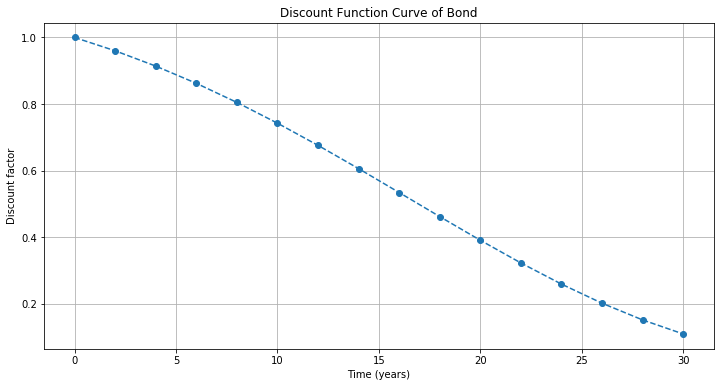

In [33]:
plt.figure(figsize = (12, 6))
plt.plot(sample_times, sample_discounts, 'o--')
plt.title("Discount Function Curve of Bond")
plt.xlabel("Time (years)")
plt.ylabel("Discount factor")
plt.show()

In [34]:
schedule = Schedule(today, calendar.advance(today, 15, Years), Period(Semiannual), 
                    calendar, ModifiedFollowing, ModifiedFollowing, DateGeneration.Backward, False)
bond = FixedRateBond(3, 100.0, schedule, [0.04], Actual360())
bond.setPricingEngine(DiscountingBondEngine(YieldTermStructureHandle(curve)))
print(bond.cleanPrice())

105.77449628297312


In [35]:
prices = []
def print_price():
	p = bond.cleanPrice()
	prices.append(p)
	print(p)
    
o = Observer(print_price)
o.registerWith(bond)

In [36]:
quotes[2].setValue(101.0)
quotes[2].setValue(100.0)

for q in quotes:
	q.setValue(101.0)

105.77449628297312
105.86560422617626
105.86560422617626
105.7744962994505
105.7744962994505
105.28388386309517
105.28388386309517
105.2186289103818
105.2186289103818
105.31959082298653
105.31959082298653
105.4878665398774
105.4878665398774
105.68032068333373
105.68032068333373
105.87580386563742
105.87580386563742
106.06201684348096
106.06201684348096
106.23044650912377
106.23044650912377
106.3740925654822
106.3740925654822
106.48708822272684
106.48708822272684
106.56505231188679
106.56505231188679
106.60570722786662
106.60570722786662
106.60980172059543
106.60980172059543
106.58011177624374
106.58011177624374
106.52070701024726


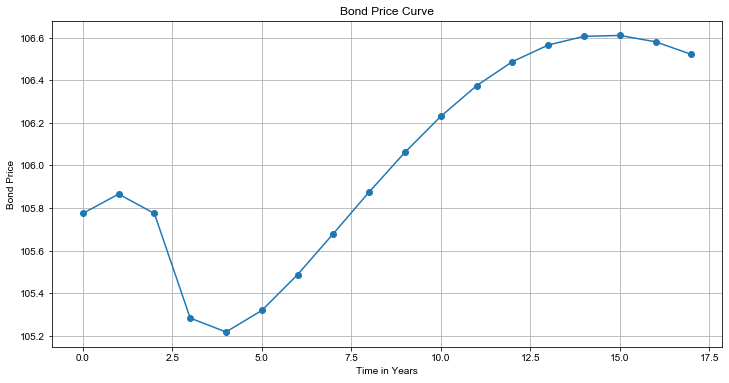

In [37]:
plt.figure(figsize = (12, 6))
plt.title("Bond Price Curve")
plt.xlabel("Time in Years")
plt.ylabel("Bond Price")
plt.style.use('seaborn-whitegrid')

unique_prices = prices[::2] + prices[-1::]
plt.plot(unique_prices, 'o-')
plt.show()

In [38]:
bond.freeze()
for q in quotes:
	q.setValue(101.5)

bond.unfreeze()

106.8583935136327


## Model Calibration

### Implied Volatility
* Data set: https://www.csie.ntu.edu.tw/~d00922011/python/data/sp500_imv.csv

In [39]:
import pandas as pd
import numpy as np

df = pd.read_csv('sp500_imv.csv', index_col  = 0)

T = df.index.values
M = np.array(df.columns.values, dtype = 'float')
V = df[df.columns.values][:].values

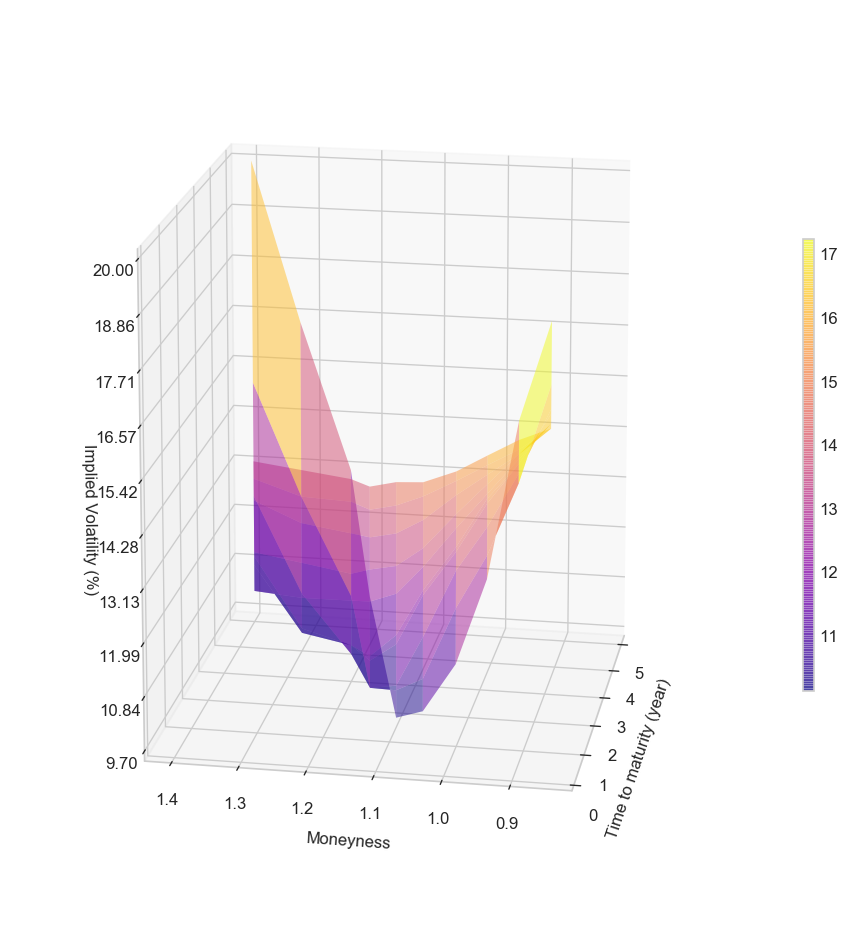

In [40]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from matplotlib import interactive
interactive(True)

fig = plt.figure(figsize = (10, 10), dpi = 120)
ax = fig.add_subplot(111, projection = '3d')
ax.set_adjustable(adjustable = 'box')
X, Y, Z = [T, M, V]
surf = ax.plot_surface(X, Y, Z * 100, cmap = cm.plasma, rstride = 1, cstride = 1, edgecolor = 'none', alpha = 0.5)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink = 0.5, aspect = 40)
ax.view_init(azim = 190, elev = 15)
ax.set_xlabel('Time to maturity (year)')
ax.set_ylabel('Moneyness')
ax.set_zlabel('Implied Volatility (%)')

plt.savefig('sp500_imv.png', dpi = 300)

#### Exercise: Implied Volatility Curve from TXO
* Data set: https://www.csie.ntu.edu.tw/~d00922011/python/data/txo20190619.CSV
* We will use `Newton-Raphson method` and the `vega` of options.
    * Newton–Raphson method: https://en.wikipedia.org/wiki/Newton%27s_method
    * Vega: https://brilliant.org/wiki/option-greeks-vega/#implications-of-put-call-parity-on-vega

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

df = pd.read_csv('./txo20190619.csv', encoding = 'big5')
df.head()

買價     賣價  成交   漲跌  單量  成交量  買量  賣量  未平倉     存續期  ...  I.V..1  Delta.1  \
0 NaN  104.0 NaN  0.0   0    0   0   1  921  0.0763  ...   67.39  -0.9912   
1 NaN  104.0 NaN  0.0   0    0   0   1  315  0.0763  ...   66.40  -0.9912   
2 NaN  104.0 NaN  0.0   0    0   0   1  120  0.0763  ...   64.04  -0.9912   
3 NaN  104.0 NaN  0.0   0    0   0   1  160  0.0763  ...   62.28  -0.9912   
4 NaN  104.0 NaN  0.0   0    0   0   1  675  0.0763  ...   61.06  -0.9912   

   Gamma.1  Theta.1  Vega.1   Rho.1   買成本.1   賣成本.1    結算.1  註記.1  
0      0.0   0.8511  0.0001 -9.6718  115500  139200  2220.0   NaN  
1      0.0   0.8180  0.0003 -9.5962  110500  134700  2120.0   NaN  
2      0.0   0.7848  0.0009 -9.5206  105500  129200  2020.0   NaN  
3      0.0   0.7513  0.0023 -9.4449  100500  124200  1920.0   NaN  
4      0.0   0.7174  0.0061 -9.3691   95500  119700  1820.0   NaN  

[5 rows x 51 columns]

In [42]:
today_date = datetime.datetime(2019, 6, 19)
maturity_date = datetime.datetime(2019, 7, 17)

time_to_maturity = (maturity_date - today_date).days
print("T = {}".format(time_to_maturity))

T = 28


In [43]:
def newton_iv(S0, K, T, option_type, price, r, init_v):
    
    from scipy.stats import norm
    
    tolerance = 1e-9
    xnew = init_v
    xold = init_v - 1
    iter_lim = 1000
    iter_cnt = 0
    
    d1 = lambda x : (np.log(S0 / K) + (r + 0.5 * x ** 2) * T) / (x * np.sqrt(T))
    d2 = lambda x : d1(x) - x * np.sqrt(T)
    vega = lambda x : S * np.sqrt(T) * norm.pdf(d1(x), 0.0, 1.0)
    
    if option_type == "C":
        fx = lambda x : S0 * norm.cdf(d1(x), 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2(x), 0.0, 1.0)
    else:
        fx = lambda x : K * np.exp(-r * T) * norm.cdf(-d2(x), 0.0, 1.0) - S0 * norm.cdf(-d1(x), 0.0, 1.0)
        
    
    while abs(xnew - xold) > tolerance and iter_cnt < iter_lim:
        
        iter_cnt += 1
        xold = xnew
        xnew = xold + (price - fx(xold)) / vega(xold)
        
    return xnew

In [44]:
S = 10585
r = 0
init_v = 0.3
T = time_to_maturity / 365.0

(rows, cols) = df.shape
df["IV_c"] = np.zeros((rows, 1))
df["IV_p"] = np.zeros((rows, 1))

for i in range(rows):
    df["IV_c"][i] = newton_iv(S, df["規格"][i], T, "C", df["成交"][i], r, init_v)
    df["IV_p"][i] = newton_iv(S, df["規格"][i], T, "P", df["成交.1"][i], r, init_v)

C:\Users\Zheng-Liang Lu\.conda\envs\Quantlib\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Zheng-Liang Lu\.conda\envs\Quantlib\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Zheng-Liang Lu\.conda\envs\Quantlib\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Zheng-Liang Lu\.conda\envs\Quantlib\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divid

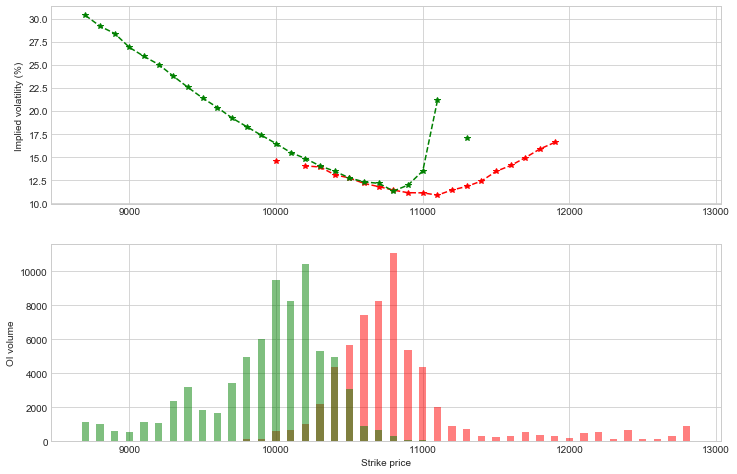

In [45]:
plt.figure(figsize = (12, 8))

plt.subplot(212)
plt.bar(df['規格'], df['未平倉'], width = 50, alpha = 0.5, color = "r")
plt.bar(df['規格'], df['未平倉.1'], width = 50, alpha = 0.5, color = "g")
plt.ylabel("OI volume")
plt.xlabel('Strike price')
left, right = plt.xlim()
plt.grid(True)

plt.subplot(211)
plt.plot(df['規格'], df['IV_c'] * 100, '*--', color = "r")
plt.plot(df['規格'], df['IV_p'] * 100, '*--', color = "g")
plt.ylabel('Implied volatility (%)')
plt.xlim(left, right)
plt.grid(True)

plt.savefig('TXO20190619_impv.png', dpi = 300)
plt.show()

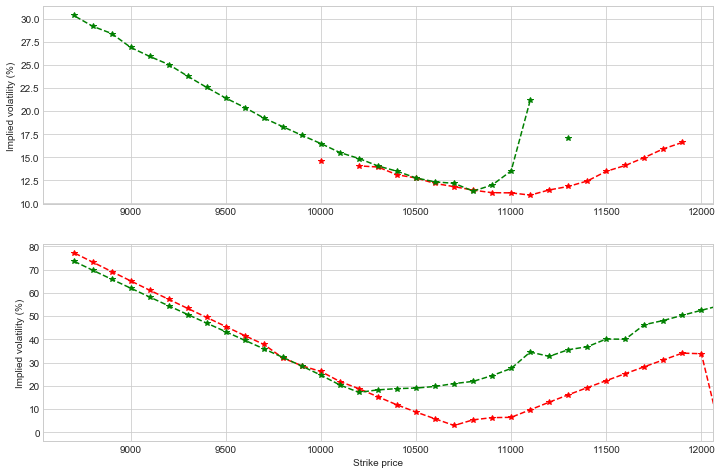

In [46]:
plt.figure(figsize = (12, 8))

plt.subplot(211)
plt.plot(df['規格'], df['IV_c'] * 100, '*--', color = "r")
plt.plot(df['規格'], df['IV_p'] * 100, '*--', color = "g")
plt.ylabel('Implied volatility (%)')
left, right = plt.xlim()

plt.subplot(212)
plt.plot(df['規格'], df['I.V.'], '*--', color = "r")
plt.plot(df['規格'], df['I.V..1'], '*--', color = "g")
plt.ylabel('Implied volatility (%)')
plt.xlabel('Strike price')
plt.xlim(left, right)

plt.savefig('TXO20190619_impv_benchmark.png', dpi = 300)
plt.show()

In [47]:
import scipy.stats

print("{:5s} {:8s} {:8s} {:8s}".format("規格", "IV (%)", "理論價", "價差"))
for idx, X in enumerate(df['規格']):
      
    v = df["IV_c"][idx]
    
    if np.isnan(v):
        continue
    
    d1 = (np.log(S / X) + (r + 0.5 * v ** 2)) / np.sqrt(T) / v
    d2 = d1 - np.sqrt(T) * v
    cc = S * scipy.stats.norm.cdf(d1) - X * np.exp(-r * T) * scipy.stats.norm.cdf(d2)
    
    print("{:5d} {:8.4f} {:8.2f} {:8.2f}".format(X, v * 100, cc, cc - df["成交"][idx]))

規格    IV (%)   理論價      價差      
11900  16.6141     0.41    -0.49
11800  15.9163     0.59    -0.51
11700  14.9734     0.74    -0.46
11600  14.1144     0.96    -0.44
11500  13.4823     1.41    -0.49
11400  12.4290     1.67    -0.43
11300  11.8397     2.61    -0.49
11200  11.4615     4.56    -0.64
11100  10.9026     7.35    -0.75
11000  11.1460    15.78    -1.22
10900  11.1642    28.87    -1.63
10800  11.4411    51.84    -2.16
10700  11.8206    86.36    -2.64
10600  12.1650   132.09    -2.91
10500  12.7615   191.86    -3.14
10400  13.1044   259.03    -2.97
10300  13.9486   339.00    -3.00
10200  14.0677   419.59    -2.41
10000  14.5871   598.57    -1.43


### Calibration on CIR Model

In [48]:
# Market Data: Eonia rate (01.10.2014) + Euribor rates
# Source: http://www.emmi-benchmarks.eu
# on 2014.9.30

t_list = np.array((1, 7, 14, 30, 60, 90, 180, 270, 360)) / 360
r_list = np.array((-0.032, -0.013, -0.013, 0.007, 0.043, 0.083, 0.183, 0.251, 0.338)) / 100

factors = (1 + t_list * r_list)
zero_rates = 1 / t_list * np.log(factors)

r0 = r_list[0]

In [49]:
import scipy.interpolate as sci

tck = sci.splrep(t_list, zero_rates, k=3)  # cubic splines
tn_list = np.linspace(0.0, 1.0, 24)
ts_list = sci.splev(tn_list, tck, der=0)
de_list = sci.splev(tn_list, tck, der=1)

f = ts_list + de_list * tn_list

Text(0, 0.5, 'Rate')

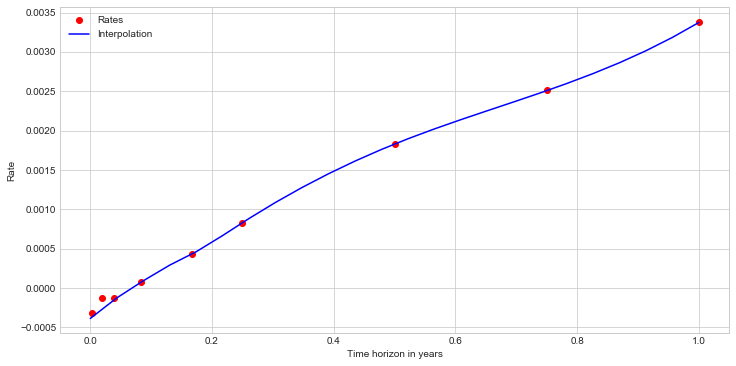

In [50]:
plt.figure(figsize = (12, 6))
plt.plot(t_list, r_list, 'ro', label = 'Rates')
plt.plot(tn_list, ts_list, 'b', label = 'Interpolation')
plt.legend()
plt.xlabel('Time horizon in years')
plt.ylabel('Rate')

In [51]:
def CIR_forward_rate(opt):
    
    kappa_r, theta_r, sigma_r = opt
    t = tn_list
    g = np.sqrt(kappa_r ** 2 + 2 * sigma_r ** 2)
    sum1 = ((kappa_r * theta_r * (np.exp(g * t) - 1)) /
            (2 * g + (kappa_r + g) * (np.exp(g * t) - 1)))
    sum2 = r0 * ((4 * g ** 2 * np.exp(g * t)) /
                 (2 * g + (kappa_r + g) * (np.exp(g * t) - 1)) ** 2)
    forward_rate = sum1 + sum2
    
    return forward_rate

def CIR_error_function(opt):
    
    kappa_r, theta_r, sigma_r = opt
    
    if 2 * kappa_r * theta_r < sigma_r ** 2: # Feller condition
        return 100000
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001: # infeasible solution
        return 100000
    
    forward_rates = CIR_forward_rate(opt)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

def CIR_calibration():
    
    from scipy.optimize import fmin
    
    init_guess = [1, 0.1, 0.1]
    opt = fmin(CIR_error_function, init_guess,
               xtol = 1e-4, ftol = 1e-4,
               maxiter = 500, maxfun = 500)
    return opt

In [52]:
opt = CIR_calibration()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 169
         Function evaluations: 318


In [53]:
print(opt)

[0.25995065 0.0610921  0.00102053]


(-0.05, 1.05)

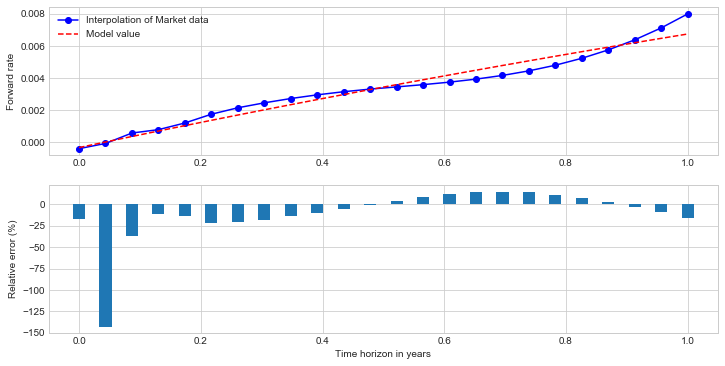

In [54]:
forward_rates = CIR_forward_rate(opt)
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.ylabel('Forward rate')
plt.plot(tn_list, f, 'bo-', label = 'Interpolation of Market data')
plt.plot(tn_list, forward_rates, 'r--', label = 'Model value')
left, right = plt.xlim()
plt.legend()

plt.subplot(212)
plt.bar(tn_list, (forward_rates - f) / f * 100, width = 0.02)
plt.xlabel('Time horizon in years')
plt.ylabel('Relative error (%)')
plt.xlim(left, right)

#### Exercise: Calibration on Heston model
* See https://www.csie.ntu.edu.tw/~d00922011/python/program/heston_calibration.zip.


#### Exercise: Volatility options
* See https://github.com/yhilpisch/py4fi/blob/master/jupyter36/19_Volatility_Options.ipynb.